In [ ]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

Step 1

Linear Model Results (Including Theta)
Z₁ = -7.511556
Z₂ = -3.770107

Risk Measures for Z₁:
Expected Loss = 7.511556
VaR_5%       = -7.511556
ES_5%        = -7.511556

Risk Measures for Z₂:
Expected Loss = 3.770107
VaR_5%       = -3.770107
ES_5%        = -3.770107


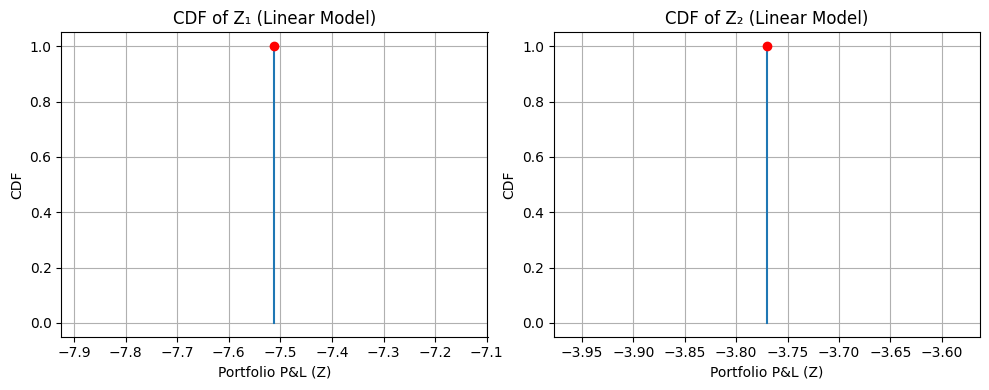

In [ ]:
# 1(a) – Linear Model

# ---------- 1. Model Parameters ----------
S0 = 100.0
r = 0.05
mu = 0.10
sigma = 0.40
T = 1.0
K = S0
M = 100_000  # Number of Monte-Carlo paths (redundant here but retained)

# ---------- 2. Black-Scholes Formulas ----------
def bs_call_price(S, K, r, sigma, tau):
    if tau <= 0:
        return max(S - K, 0.0)
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r*tau) * norm.cdf(d2)

def bs_call_delta(S, K, r, sigma, tau):
    if tau <= 0:
        return 1.0 if S > K else 0.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma * np.sqrt(tau))
    return norm.cdf(d1)

def bs_call_theta(S, K, r, sigma, tau):
    if tau <= 0:
        return 0.0
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    term1 = -(S * norm.pdf(d1) * sigma) / (2 * np.sqrt(tau))
    term2 = -r * K * np.exp(-r*tau) * norm.cdf(d2)
    return term1 + term2

# ---------- 3. Compute Greeks at t=0 ----------
C0 = bs_call_price(S0, K, r, sigma, T)
Delta0 = bs_call_delta(S0, K, r, sigma, T)
Theta0 = bs_call_theta(S0, K, r, sigma, T)
delta_cash = Delta0 * S0 - C0  # Cash position: ΔS₀ - C₀

# ---------- 4. Compute Z₁ and Z₂ (Linear Model) ----------
# Linear model: ΔC ≈ ΔΔS + ΘΔt
t1 = T  # For Z₁ (i=1)
t2 = T/2  # For Z₂ (i=2)

Z1_val = Theta0 * t1 + delta_cash * (np.exp(r * t1) - 1)
Z2_val = Theta0 * t2 + delta_cash * (np.exp(r * t2) - 1)

# ---------- 5. Override with Deterministic Results ----------
Z1 = np.full(M, Z1_val)  # All paths have the same value
Z2 = np.full(M, Z2_val)

# ---------- 6. Risk Measures ----------
def expected_loss(samples):
    return -np.mean(samples)

def var_alpha(samples, alpha=0.05):
    return np.quantile(samples, alpha)

def es_alpha(samples, alpha=0.05):
    VaR = var_alpha(samples, alpha)
    return samples[samples <= VaR].mean()

# ---------- 7. Results ----------
print("Linear Model Results (Including Theta)")
print(f"Z₁ = {Z1_val:.6f}")
print(f"Z₂ = {Z2_val:.6f}\n")

print("Risk Measures for Z₁:")
print(f"Expected Loss = {expected_loss(Z1):.6f}")
print(f"VaR_5%       = {var_alpha(Z1):.6f}")
print(f"ES_5%        = {es_alpha(Z1):.6f}\n")

print("Risk Measures for Z₂:")
print(f"Expected Loss = {expected_loss(Z2):.6f}")
print(f"VaR_5%       = {var_alpha(Z2):.6f}")
print(f"ES_5%        = {es_alpha(Z2):.6f}")

# ---------- 8. Plot CDFs ----------
def plot_cdf(data, title):
    plt.step([data[0], data[0]], [0, 1], where='post')
    plt.scatter(data[0], 1, color='red', zorder=5)
    plt.xlabel("Portfolio P&L (Z)")
    plt.ylabel("CDF")
    plt.title(title)
    plt.grid(True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_cdf(Z1, "CDF of Z₁ (Linear Model)")
plt.subplot(1, 2, 2)
plot_cdf(Z2, "CDF of Z₂ (Linear Model)")
plt.tight_layout()
plt.show()


--- t = 1 yr ---
Expected-Loss : -3.077555
VaR (5 %)     : -7.480158
ES  (5 %)     : -7.501215

--- t = 0.5 yr ---
Expected-Loss : -0.654631
VaR (5 %)     : -3.755624
ES  (5 %)     : -3.765245


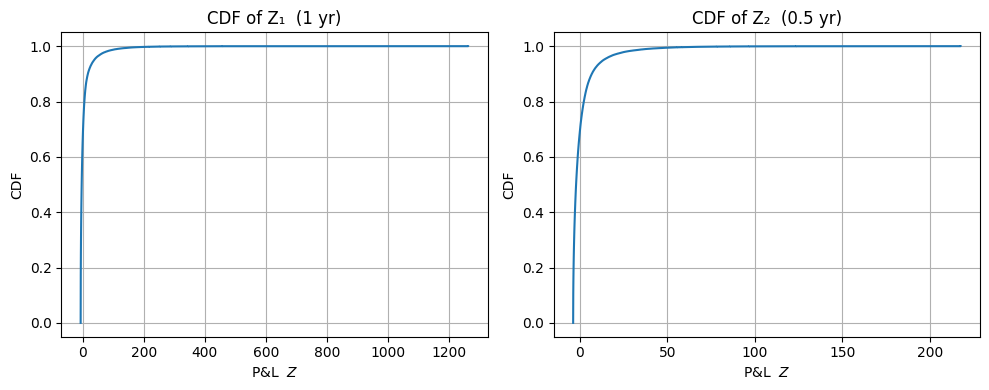

In [ ]:
# 1 (b) – Quadratic (Δ–Γ) Model
# -----------------------------------------------------------

# ---------- 1. Parameters ----------
S0, r, mu, sigma = 100.0, 0.05, 0.10, 0.40
T, K             = 1.0, 100.0          # maturity and ATM strike
M                = 100_000             # Monte-Carlo paths
t1, t2           = T, T/2              # horizons

# ---------- 2. Black-Scholes Greeks at t = 0 ----------
def d1_d2(S,K,r,sig,tau):
    d1 = (np.log(S/K)+(r+0.5*sig**2)*tau)/(sig*np.sqrt(tau))
    return d1, d1-sig*np.sqrt(tau)

def bs_price(S,K,r,sig,tau):
    d1,d2 = d1_d2(S,K,r,sig,tau)
    return S*norm.cdf(d1)-K*np.exp(-r*tau)*norm.cdf(d2)

def bs_delta(S,K,r,sig,tau):
    d1,_ = d1_d2(S,K,r,sig,tau)
    return norm.cdf(d1)

def bs_gamma(S,K,r,sig,tau):
    d1,_ = d1_d2(S,K,r,sig,tau)
    return norm.pdf(d1)/(S*sig*np.sqrt(tau))

def bs_theta(S,K,r,sig,tau):
    d1,d2 = d1_d2(S,K,r,sig,tau)
    term1 = -(S*norm.pdf(d1)*sig)/(2*np.sqrt(tau))
    term2 = -r*K*np.exp(-r*tau)*norm.cdf(d2)
    return term1 + term2            # calendar-time θ

C0     = bs_price(S0,K,r,sigma,T)
Delta0 = bs_delta(S0,K,r,sigma,T)
Gamma0 = bs_gamma(S0,K,r,sigma,T)
Theta0 = bs_theta(S0,K,r,sigma,T)
delta  = Delta0*S0 - C0            # cash leg

# ---------- 3. Simulate S_t under physical drift μ ----------
Z1 = np.random.randn(M)
Z2 = np.random.randn(M)
ST1 = S0*np.exp((mu-0.5*sigma**2)*t1 + sigma*np.sqrt(t1)*Z1)
ST2 = S0*np.exp((mu-0.5*sigma**2)*t2 + sigma*np.sqrt(t2)*Z2)

# ---------- 4. Quadratic-model P&L samples ----------
def quad_pnl(ST, t):
    return (Theta0*t
            + 0.5*Gamma0*(ST-S0)**2
            + delta*(np.exp(r*t)-1))

Z1_samples = quad_pnl(ST1, t1)
Z2_samples = quad_pnl(ST2, t2)

# ---------- 5. Risk measures ----------
def exp_loss(x): return -x.mean()
def var05(x):    return np.quantile(x, 0.05)
def es05(x):
    v = var05(x)
    return x[x<=v].mean()

for lbl, samp in [("t = 1 yr", Z1_samples), ("t = 0.5 yr", Z2_samples)]:
    print(f"\n--- {lbl} ---")
    print(f"Expected-Loss : {exp_loss(samp):.6f}")
    print(f"VaR (5 %)     : {var05(samp):.6f}")
    print(f"ES  (5 %)     : {es05(samp):.6f}")

# ---------- 6. (Optional) empirical CDF plots ----------
def ecdf(x, ax, title):
    xs = np.sort(x); ys = np.arange(1,len(x)+1)/len(x)
    ax.step(xs, ys, where="post")
    ax.set_xlabel("P&L  $Z$"); ax.set_ylabel("CDF"); ax.grid(True)
    ax.set_title(title)

plt.figure(figsize=(10,4))
ecdf(Z1_samples, plt.subplot(1,2,1), "CDF of Z₁  (1 yr)")
ecdf(Z2_samples, plt.subplot(1,2,2), "CDF of Z₂  (0.5 yr)")
plt.tight_layout(); plt.show()

Exact Distribution – Risk Measures
[Z1] Expected Loss = -0.130842
[Z1] VaR_5%       = -14.563254
[Z1] ES_5%        = -15.154259

[Z2] Expected Loss = -0.028674
[Z2] VaR_5%       = -4.535447
[Z2] ES_5%        = -4.548706


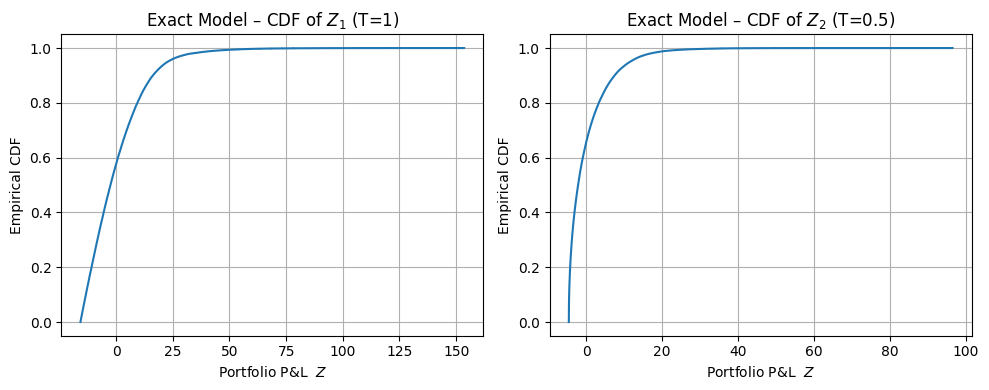

In [ ]:
#  1 (c) – Exact Distribution (Black-Scholes Pricing)

# ---------- 1. Model Parameters ----------
S0    = 100.0
r     = 0.05
mu    = 0.10
sigma = 0.40
T     = 1.0
K     = S0
M     = 100_000

# ---------- 2. Black-Scholes Formulas ----------
def bs_call_price(S, K, r, sigma, tau):
    if tau <= 0:
        return np.maximum(S - K, 0.0)
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    d2 = d1 - sigma * np.sqrt(tau)
    return S * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

def bs_call_delta(S, K, r, sigma, tau):
    if tau <= 0:
        return np.where(S > K, 1.0, 0.0)  # Delta at maturity
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * tau) / (sigma * np.sqrt(tau))
    return norm.cdf(d1)

# ---------- 3. Initial Hedge and Cash ----------
tau0 = T
C0 = bs_call_price(S0, K, r, sigma, tau0)
Delta0 = bs_call_delta(S0, K, r, sigma, tau0)
delta_cash = Delta0 * S0 - C0

# ---------- 4. Simulate Stock Paths (Physical Measure) ----------
# Simulate S_T
dt_T = T
Z_T = np.random.randn(M)
ST = S0 * np.exp((mu - 0.5 * sigma**2) * dt_T + sigma * np.sqrt(dt_T) * Z_T)
# Simulate S_{T/2}
dt_Thalf = T/2
Z_Thalf = np.random.randn(M)
ST_half = S0 * np.exp((mu - 0.5 * sigma**2) * dt_Thalf + sigma * np.sqrt(dt_Thalf) * Z_Thalf)

# ---------- 5. Compute Exact Call Prices ----------
C_T = np.maximum(ST - K, 0.0)
C_Thalf = bs_call_price(ST_half, K, r, sigma, T/2)

# ---------- 6. Portfolio Values ----------
V_T = C_T - Delta0 * ST + delta_cash * np.exp(r * T)
V_Thalf = C_Thalf - Delta0 * ST_half + delta_cash * np.exp(r * T/2)

# P&L: Z_i = V(t) - V(0) = V(t) (since V(0) = 0)
Z1 = V_T
Z2 = V_Thalf

# ---------- 7. Risk Measures ----------
def expected_loss(samples):
    return -np.mean(samples)
def var_alpha(samples, alpha=0.05):
    return np.quantile(samples, alpha)
def es_alpha(samples, alpha=0.05):
    VaR = var_alpha(samples, alpha)
    return samples[samples <= VaR].mean()

# ---------- 8. Results ----------
print("Exact Distribution – Risk Measures")
print(f"[Z1] Expected Loss = {expected_loss(Z1):.6f}")
print(f"[Z1] VaR_5%       = {var_alpha(Z1):.6f}")
print(f"[Z1] ES_5%        = {es_alpha(Z1):.6f}\n")

print(f"[Z2] Expected Loss = {expected_loss(Z2):.6f}")
print(f"[Z2] VaR_5%       = {var_alpha(Z2):.6f}")
print(f"[Z2] ES_5%        = {es_alpha(Z2):.6f}")

# ---------- 9. Plot Empirical CDFs ----------
def plot_ecdf(data, title):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    plt.step(x, y, where="post")
    plt.xlabel("Portfolio P&L  $Z$")
    plt.ylabel("Empirical CDF")
    plt.title(title)
    plt.grid(True)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plot_ecdf(Z1, r"Exact Model – CDF of $Z_1$ (T=1)")
plt.subplot(1, 2, 2)
plot_ecdf(Z2, r"Exact Model – CDF of $Z_2$ (T=0.5)")
plt.tight_layout()
plt.show()

Step 2

In [ ]:
# Parameters
S0 = 100      # Initial stock price
K = 100       # Strike price (at-the-money)
r = 0.05      # Risk-free rate
sigma = 0.4   # Volatility
T = 1         # Maturity in years
N = 100_000_000   # Number of Monte-Carlo simulations

# Theoretical Black-Scholes calculations
d1 = (np.log(S0 / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
d2 = d1 - sigma * np.sqrt(T)
N_d1 = norm.cdf(d1)
N_minus_d1 = norm.cdf(-d1)
N_minus_d2 = norm.cdf(-d2)

theoretical_price = K * np.exp(-r * T) * N_minus_d2 - S0 * N_minus_d1
theoretical_delta = N_d1 - 1  # Delta for put option: N(d1) - 1
theoretical_vega = S0 * np.sqrt(T) * norm.pdf(d1)  # Vega (same for call and put)

# Monte-Carlo simulation
np.random.seed(42)  # For reproducibility
Z = np.random.normal(0, 1, N)  # Standard normal variables
mu = (r - 0.5 * sigma**2) * T
sigma_T = sigma * np.sqrt(T)
S_T = S0 * np.exp(mu + sigma_T * Z)  # Stock price at maturity
discount = np.exp(-r * T)
indicator = (S_T < K).astype(float)  # Indicator for S_T < K

# Price estimate
payoff = np.maximum(K - S_T, 0)
mc_price = discount * np.mean(payoff)
price_std_err = discount * np.std(payoff) / np.sqrt(N)

# Delta estimate: -e^{-rT} * (S_T / S0) * I{S_T < K}
delta_terms = -discount * (S_T / S0) * indicator
mc_delta = np.mean(delta_terms)
delta_std_err = np.std(delta_terms) / np.sqrt(N)

# Vega estimate: e^{-rT} * S_T * (sigma * T - sqrt(T) * Z) * I{S_T < K}
vega_terms = discount * S_T * (sigma * T - np.sqrt(T) * Z) * indicator
mc_vega = np.mean(vega_terms)
vega_std_err = np.std(vega_terms) / np.sqrt(N)

# Output results
print("Black-Scholes Monte-Carlo Results")
print("--------------------------------")
print(f"Theoretical Price: {theoretical_price:.6f}")
print(f"Monte-Carlo Price: {mc_price:.4f} ± {price_std_err:.6f}")
print(f"Theoretical Delta: {theoretical_delta:.6f}")
print(f"Monte-Carlo Delta: {mc_delta:.4f} ± {delta_std_err:.6f}")
print(f"Theoretical Vega:  {theoretical_vega:.6f}")
print(f"Monte-Carlo Vega:  {mc_vega:.6f} ± {vega_std_err:.6f}")
print("\nDiscussion:")
print("- Delta and Vega estimates are close to theoretical values, with small standard errors due to large N (100,000,000).")
print("- Gamma cannot be estimated using the direct pathwise method because the payoff (K - S_T)^+ is not twice")
print("  differentiable with respect to S0 at S_T = K, where the first derivative has a discontinuity.")

Black-Scholes Monte-Carlo Results
--------------------------------
Theoretical Price: 13.145894
Monte-Carlo Price: 13.1486 ± 0.001680
Theoretical Delta: -0.372591
Monte-Carlo Delta: -0.3726 ± 0.000037
Theoretical Vega:  37.841983
Monte-Carlo Vega:  37.846389 ± 0.003856

Discussion:
- Delta and Vega estimates are close to theoretical values, with small standard errors due to large N (100,000,000).
- Gamma cannot be estimated using the direct pathwise method because the payoff (K - S_T)^+ is not twice
  differentiable with respect to S0 at S_T = K, where the first derivative has a discontinuity.
